### Guided Project: Optimizing Model Prediction



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


In [7]:
fires = pd.read_csv('fires.csv').dropna()

The reference model will only use __temp__ and __wind__ as features, so keep that in mind for later. The outcome of interest is the __area__ column, which represents the total area damaged by the fire.


1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84


In [8]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329 entries, 3 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  329 non-null    int64  
 1   X           329 non-null    int64  
 2   Y           329 non-null    int64  
 3   month       329 non-null    object 
 4   day         329 non-null    object 
 5   FFMC        329 non-null    float64
 6   DMC         329 non-null    float64
 7   DC          329 non-null    float64
 8   ISI         329 non-null    float64
 9   temp        329 non-null    float64
 10  RH          329 non-null    float64
 11  wind        329 non-null    float64
 12  rain        329 non-null    float64
 13  area        329 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 38.6+ KB


In [9]:
fires.isnull().sum()

Unnamed: 0    0
X             0
Y             0
month         0
day           0
FFMC          0
DMC           0
DC            0
ISI           0
temp          0
RH            0
wind          0
rain          0
area          0
dtype: int64

In [11]:

fires_reference = fires[["wind", "temp", "area"]].dropna()
reference_X = fires_reference[["wind", "temp"]]

reference = LinearRegression()
for col in fires.columns:
    num_na = sum(pd.isna(fires[col]))
    print(f"The {col} column has {num_na} missing values.")

The Unnamed: 0 column has 0 missing values.
The X column has 0 missing values.
The Y column has 0 missing values.
The month column has 0 missing values.
The day column has 0 missing values.
The FFMC column has 0 missing values.
The DMC column has 0 missing values.
The DC column has 0 missing values.
The ISI column has 0 missing values.
The temp column has 0 missing values.
The RH column has 0 missing values.
The wind column has 0 missing values.
The rain column has 0 missing values.
The area column has 0 missing values.


# Data Cleaning

First, we'll convert the month column into a categorical feature. Instead of using the strings, we'll convert it into an indicator for the summer months in the northern hemisphere.

For the sake of completion, we'll impute all of the features so that we can have the biggest set to choose from for sequential feature selection. We'll go with K-nearest neighbors imputation since we expect area damage to be similar among similar fires.



array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

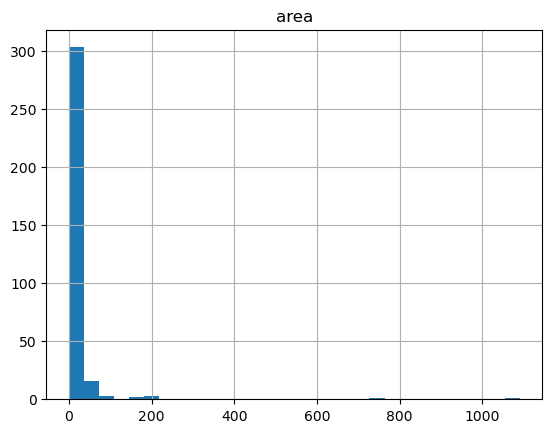

In [12]:
fires.hist("area", bins=30)


The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero. It might be worth it to log-transform the data. Note though that some of the outcomes are actually 0, so we can add 1 to prevent any errors. Recall that __loga()__  is undefined.

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

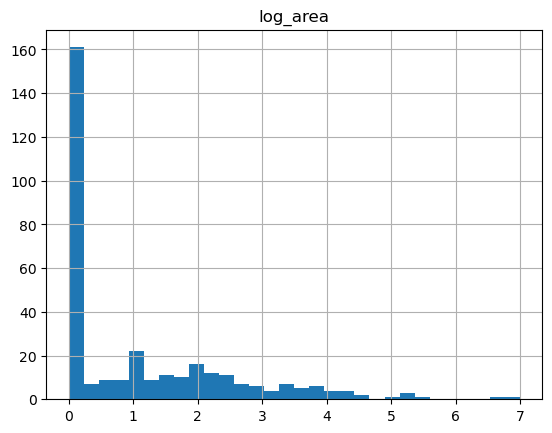

In [13]:
fires["log_area"] = np.log(fires["area"] + 1)

fires.hist("log_area", bins=30)

We can see that performing a log-transformation doesn't produce a bell-shaped distribution, but it does spread out the data a bit more than without the transformation. It's probably the case that most fires do not appreciably damage the forest, so we would be mistaken in removing all of these rows.

Instead of using month directly, we'll derive another feature called __summer__ that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely.



In [28]:
def is_summer_month(month):
    if month in ["jun", "jul", "aug"]:
        return 1
    else:
        return 0

fires["summer"] = [is_summer_month(m) for m in fires["month"]]

fires['summer'].isnull().sum()
fires.shape

(329, 16)

In [15]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fires_missing = fires[fires.columns[5:13]] # FFMC to rain
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed


,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2
1,92.3,85.3,488.0,14.7,22.2,29.0,5.4,0.0
2,92.3,88.9,495.6,8.5,24.1,27.0,3.1,0.0
3,91.5,145.4,608.2,10.7,8.0,86.0,2.2,0.0
4,91.0,129.5,692.6,7.0,13.1,63.0,5.4,0.0
...,...,...,...,...,...,...,...,...
324,81.6,56.7,665.6,1.9,27.8,32.0,2.7,0.0
325,81.6,56.7,665.6,1.9,21.9,71.0,5.8,0.0
326,81.6,56.7,665.6,1.9,21.2,70.0,6.7,0.0
327,94.4,146.0,614.7,11.3,25.6,42.0,4.0,0.0


We'll examine the data for outliers using boxplots:



<AxesSubplot:>

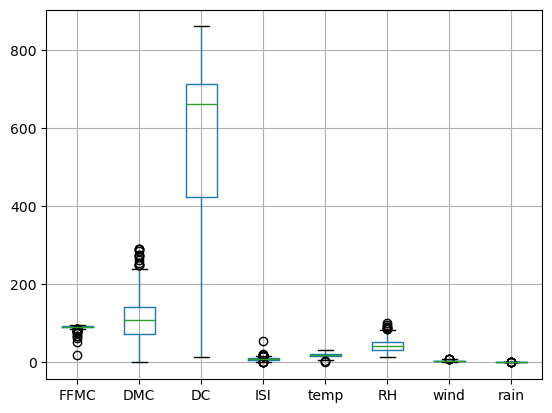

In [16]:
imputed.boxplot(column=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"])


The dots indicate that there are some outliers in the data. Let's examine the number of outliers in each of the columns.



In [17]:
for col in imputed:

    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")


The FFMC column has 31 according to the boxplot method.
The DMC column has 13 according to the boxplot method.
The DC column has 0 according to the boxplot method.
The ISI column has 25 according to the boxplot method.
The temp column has 3 according to the boxplot method.
The RH column has 7 according to the boxplot method.
The wind column has 5 according to the boxplot method.
The rain column has 7 according to the boxplot method.


Despite the visual cue in the boxplots, based on the actual calculations, there don't seem to be any outliers. In this case, we'll leave the dataset as-is.

Now that the dataset has been inspected for missing values and outliers, we can proceed to standardize it. These standardized values will help for standardization. Afterwards, we'll append the __summmer__ feature back into the dataset.



In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = fires.columns[5:13])

print(scaled.shape)
print(fires.shape)
final = pd.concat([fires["summer"].reset_index(drop=True), 
                   scaled.reset_index(drop=True)], axis=1,ignore_index=True)

columns = ["summer","FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"]

final.columns = columns
final



(329, 8)
(329, 16)


,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,0.181862,-1.230859,-1.822093,-0.006866,-1.900243,3.231670,0.036821,1.601453
1,1,0.282931,-0.418460,-0.206236,1.207808,0.593158,-0.983273,0.856131,-0.126016
2,1,0.282931,-0.362217,-0.176320,-0.113416,0.933982,-1.107242,-0.489879,-0.126016
3,1,0.148172,0.520485,0.266908,0.355405,-1.954057,2.549841,-1.016578,-0.126016
4,0,0.063949,0.272078,0.599133,-0.433067,-1.039212,1.124198,0.856131,-0.126016
...,...,...,...,...,...,...,...,...,...
324,1,-1.519459,-0.865279,0.492853,-1.519881,1.597693,-0.797320,-0.723967,-0.126016
325,1,-1.519459,-0.865279,0.492853,-1.519881,0.539343,1.620074,1.090220,-0.126016
326,1,-1.519459,-0.865279,0.492853,-1.519881,0.413777,1.558090,1.616920,-0.126016
327,1,0.636671,0.529859,0.292494,0.483266,1.203054,-0.177475,0.036821,-0.126016


In [48]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires["log_area"]

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")


forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                       n_features_to_select=6, 
                                       direction="forward")


forward2.fit(final, y)
forward4.fit(final, y)
forward6.fit(final, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())


Features selected in 2 feature model: ['temp' 'rain']
Features selected in 4 feature model: ['FFMC' 'temp' 'wind' 'rain']
Features selected in 6 feature model: ['FFMC' 'DC' 'ISI' 'temp' 'wind' 'rain']


In [49]:
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                       n_features_to_select=6, 
                                       direction="backward")

backward2.fit(final, y)
backward4.fit(final, y)
backward6.fit(final, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())


Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'wind' 'rain']
Features selected in 6 feature model: ['FFMC' 'DC' 'ISI' 'RH' 'wind' 'rain']


Based on the features chosen by forward and backward selection, it seems like DC, wind and FFMC seem to be the most impactful on predicting log_area.



In [50]:
fw2_model = LinearRegression() # .fit(final[forward2.get_feature_names_out()], y)
fw4_model = LinearRegression() # .fit(final[forward4.get_feature_names_out()], y)
fw6_model = LinearRegression() # .fit(final[forward6.get_feature_names_out()], y)

bw2_model = LinearRegression() # .fit(final[backward2.get_feature_names_out()], y)
bw4_model = LinearRegression() # .fit(final[backward4.get_feature_names_out()], y)
bw6_model = LinearRegression() # .fit(final[backward6.get_feature_names_out()], y)


# More Candidate Models


Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damaage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model. There are such models; however, they were beyond the scope of the course, but they might be plausible candidates for further next steps.

In [52]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)


Ridge tuning parameter:  181.16216216216216
LASSO tuning parameter:  10000.0
Ridge coefficients:  [-0.08968045  0.00635913  0.07611265  0.03819539 -0.03252456  0.08009822
 -0.03112312  0.06784624 -0.07066996]
LASSO coefficients:  [-0.  0.  0.  0.  0.  0. -0.  0. -0.]


The LASSO tuning parameter always seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. We'll try to home in on a better tuning parameter value below by choosing a smaller range to pick from.



In [53]:
ridge = RidgeCV(alphas = np.linspace(1000, 1500, num=1000))
ridge.fit(final, y)
print("Ridge tuning parameter: ", ridge.alpha_)


Ridge tuning parameter:  1000.0


We'll use this value in k-fold cross-validation, rounded to the hundredths place. We'll use a ridge regression and choose not to use a LASSO model here since the regularization results aren't helpful.

# K-Fold Cross-Validation


In [54]:
from sklearn.model_selection import cross_val_score 

reference_cv = cross_val_score(reference, final[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, final[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, final[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, final[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model, final[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, final[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, final[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, final, y, cv = 5, scoring = "neg_mean_squared_error")


print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))


Reference Model, Avg Test MSE:  -2.2835505549710393  SD:  1.0798634281647903
Forward-2 Model, Avg Test MSE:  -2.2824587425583207  SD:  1.0651004733763711
Forward-4 Model, Avg Test MSE:  -2.3025611911914092  SD:  1.0622404415707172
Forward-6 Model, Avg Test MSE:  -2.333329534967472  SD:  1.0300709939555228
Backward-2 Model, Avg Test MSE:  -2.298235228964477  SD:  1.037561322445674
Backward-4 Model, Avg Test MSE:  -2.3010524886749346  SD:  1.0145720948444596
Backward-6 Model, Avg Test MSE:  -2.3248199236341103  SD:  0.9900849695423978
Ridge Model, Avg Test MSE:  -2.3248199236341103  SD:  0.9900849695423978


Among our candidate models, the backward selection model using two features performs the best, with an average MSE of -2.17. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.

However, this problem is known to be a difficult one. The extreme skew in the outcome hurts many of the assumptions needed by linear models. We hope that this showcases that machine learning is not a universal fix. Several problems have characteristics that make prediction difficult.